# Identify Fraud from Enron Email (Bayesian optimization)

Using [HyperOpt](https://github.com/hyperopt/hyperopt) and [Gradient Boosting](https://lightgbm.readthedocs.io/en/latest/index.html) for selecting best hyper parameters
For reference, also see: https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0


In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import random
from timeit import default_timer as timer
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

MAX_EVALS = 200
N_FOLDS = 5

%matplotlib inline

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

enron_data = pd.DataFrame.from_dict(data_dict)

enron_data

,METTS MARK,BAXTER JOHN C,ELLIOTT STEVEN,CORDES WILLIAM R,HANNON KEVIN P,MORDAUNT KRISTINA M,MEYER ROCKFORD G,MCMAHON JEFFREY,HAEDICKE MARK E,PIPER GREGORY F,...,SAVAGE FRANK,IZZO LAWRENCE L,TILNEY ELIZABETH A,MARTIN AMANDA K,BUY RICHARD B,GRAMM WENDY L,CAUSEY RICHARD A,TAYLOR MITCHELL S,DONAHUE JR JEFFREY M,GLISAN JR BEN F
bonus,600000,1200000,350000,NaN,1500000,325000,NaN,2600000,1150000,400000,...,NaN,NaN,300000,NaN,900000,NaN,1000000,600000,800000,600000
deferral_payments,NaN,1295738,NaN,NaN,NaN,NaN,1848227,NaN,2157527,1130036,...,NaN,NaN,NaN,85430,649584,NaN,NaN,227449,NaN,NaN
deferred_income,NaN,-1386055,-400729,NaN,-3117011,NaN,NaN,NaN,-934484,-33333,...,-121284,NaN,-575000,NaN,-694862,NaN,-235000,NaN,-300000,NaN
director_fees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,125034,NaN,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN
email_address,mark.metts@enron.com,NaN,steven.elliott@enron.com,bill.cordes@enron.com,kevin.hannon@enron.com,kristina.mordaunt@enron.com,rockford.meyer@enron.com,jeffrey.mcmahon@enron.com,mark.haedicke@enron.com,greg.piper@enron.com,...,NaN,larry.izzo@enron.com,elizabeth.tilney@enron.com,a..martin@enron.com,rick.buy@enron.com,NaN,richard.causey@enron.com,mitchell.taylor@enron.com,jeff.donahue@enron.com,ben.glisan@enron.com
exercised_stock_options,NaN,6680544,4890344,651850,5538001,NaN,493489,1104054,608750,880290,...,NaN,2165172,591250,2070306,2542813,NaN,NaN,3181250,765920,384728
expenses,94299,11200,78552,NaN,34039,35018,NaN,137108,76169,43057,...,NaN,28093,NaN,8211,NaN,NaN,30674,NaN,96268,125978
from_messages,29,NaN,NaN,12,32,NaN,28,48,1941,222,...,NaN,19,19,230,1053,NaN,49,29,22,16
from_poi_to_this_person,38,NaN,NaN,10,32,NaN,0,58,180,61,...,NaN,28,10,8,156,NaN,58,0,188,52
from_this_person_to_poi,1,NaN,NaN,0,21,NaN,0,26,61,48,...,NaN,5,11,0,71,NaN,12,0,11,6


In [3]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = list(data_dict['METTS MARK'].keys())
features_list.remove('poi')
features_list.remove('email_address')
features_list.remove('total_payments')
features_list.remove('total_stock_value')
features_list.remove('other')


In [4]:
### Task 2: Remove outliers
data_dict.pop('TOTAL')
data_dict.pop('THE TRAVEL AGENCY IN THE PARK')


{'salary': 'NaN',
 'to_messages': 'NaN',
 'deferral_payments': 'NaN',
 'total_payments': 362096,
 'loan_advances': 'NaN',
 'bonus': 'NaN',
 'email_address': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'deferred_income': 'NaN',
 'total_stock_value': 'NaN',
 'expenses': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'exercised_stock_options': 'NaN',
 'from_messages': 'NaN',
 'other': 362096,
 'from_this_person_to_poi': 'NaN',
 'poi': False,
 'long_term_incentive': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'restricted_stock': 'NaN',
 'director_fees': 'NaN'}

In [5]:
# Remove columns with > 50% NaN's
df = pd.DataFrame(data_dict).T
df.replace(to_replace='NaN', value=np.nan, inplace=True)
for key in features_list:
    if df[key].isnull().sum() > df.shape[0] * 0.5:
        features_list.remove(key)
features_list = ['poi'] + features_list


In [6]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

In [7]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [8]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt'],
    'num_leaves': list(range(4, 50)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(2, 12, 2)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))


Text(0.5, 1.0, 'Learning Rate Distribution')

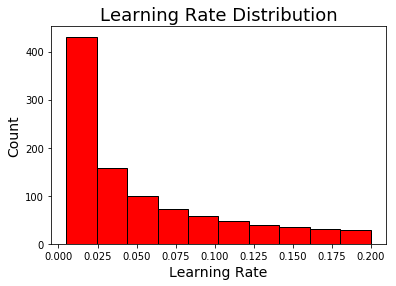

In [9]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k')
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18)


Text(0.5, 1.0, 'Number of Leaves Distribution')

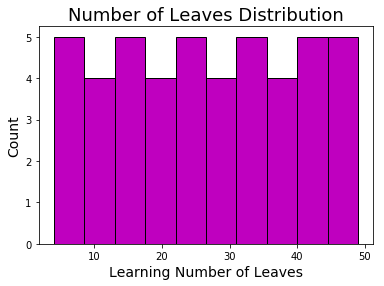

In [10]:
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18)


In [11]:
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'class_weight': 'balanced',
 'boosting_type': 'gbdt',
 'num_leaves': 11,
 'learning_rate': 0.11622282790624151,
 'subsample_for_bin': 100000,
 'min_child_samples': 4,
 'reg_alpha': 0.673469387755102,
 'reg_lambda': 0.24489795918367346,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 0.6919191919191919}

In [12]:
train_set = lgb.Dataset(np.asarray(features), label = np.asarray(labels))
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

In [13]:
def random_objective(params, iteration, n_folds = 10):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    params['verbose'] = -1
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 50, metrics = 'binary_logloss', seed = 50, verbose_eval=-1)
    end = timer()
    loss = np.min(cv_results['binary_logloss-mean'])
    
    # Loss must be minimized
    # loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmin(cv_results['binary_logloss-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

In [16]:
for i in tqdm(range(MAX_EVALS)):
    
#     print(i)
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
#     print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


In [17]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,loss,params,iteration,estimators,time
0,0.302208,"{'class_weight': None, 'boosting_type': 'gbdt'...",18,25,0.154667
1,0.304174,"{'class_weight': 'balanced', 'boosting_type': ...",20,140,0.165639
2,0.305384,"{'class_weight': None, 'boosting_type': 'gbdt'...",62,14,0.0708586
3,0.306278,"{'class_weight': None, 'boosting_type': 'gbdt'...",69,345,0.328042
4,0.30639,"{'class_weight': None, 'boosting_type': 'gbdt'...",113,8,0.100002


In [18]:
random_results.loc[0, 'params']

{'class_weight': None,
 'boosting_type': 'gbdt',
 'num_leaves': 38,
 'learning_rate': 0.09176075208743704,
 'subsample_for_bin': 160000,
 'min_child_samples': 2,
 'reg_alpha': 0.8979591836734693,
 'reg_lambda': 0.12244897959183673,
 'colsample_bytree': 0.7333333333333333,
 'subsample': 0.7525252525252526,
 'verbose': -1}

In [19]:
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = 30, 
                                       objective = 'binary', **best_random_params, random_state = 50)
# Fit on the training data
best_random_model.fit(features, labels)


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7333333333333333, importance_type='split',
        learning_rate=0.09176075208743704, max_depth=-1,
        min_child_samples=2, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=25, n_jobs=30, num_leaves=38, objective='binary',
        random_state=50, reg_alpha=0.8979591836734693,
        reg_lambda=0.12244897959183673, silent=True,
        subsample=0.7525252525252526, subsample_for_bin=160000,
        subsample_freq=0, verbose=-1)

In [20]:
dump_classifier_and_data(best_random_model, my_dataset, features_list)

In [21]:
%run -i 'tester.py'

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7333333333333333, importance_type='split',
        learning_rate=0.09176075208743704, max_depth=-1,
        min_child_samples=2, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=25, n_jobs=30, num_leaves=38, objective='binary',
        random_state=50, reg_alpha=0.8979591836734693,
        reg_lambda=0.12244897959183673, silent=True,
        subsample=0.7525252525252526, subsample_for_bin=160000,
        subsample_freq=0, verbose=-1)
	Accuracy: 0.86393	Precision: 0.46751	Recall: 0.14750	F1: 0.22425	F2: 0.17090
	Total predictions: 15000	True positives:  295	False positives:  336	False negatives: 1705	True negatives: 12664



<Figure size 432x288 with 0 Axes>

In [22]:
import csv
from hyperopt import STATUS_OK

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    params['verbose'] = -1
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 50, metrics = 'binary_logloss', seed = 50, verbose_eval=-1)
    
    run_time = timer() - start
    
    # Extract the best score
    loss = np.min(cv_results['binary_logloss-mean'])
    
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmin(cv_results['binary_logloss-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open('./bay_opt.csv', 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [27]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
import seaborn as sns


In [28]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

/home/kang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Density')

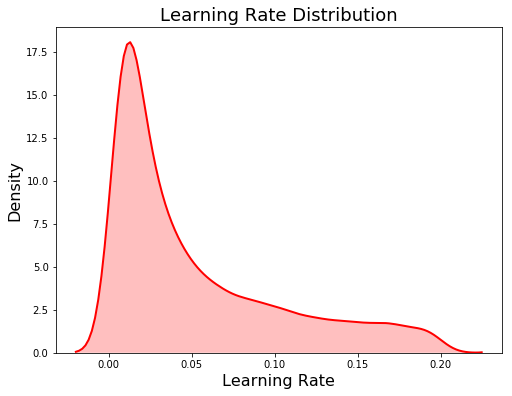

In [29]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16)

Text(0, 0.5, 'Density')

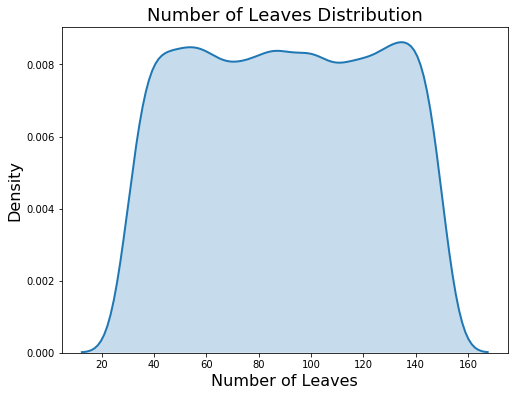

In [30]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True)
plt.title('Number of Leaves Distribution', size = 18)
plt.xlabel('Number of Leaves', size = 16)
plt.ylabel('Density', size = 16)

In [31]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}
                                            ])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'gbdt', 'subsample': 0.9741739825862665}}

In [32]:

# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

{'boosting_type': 'gbdt', 'subsample': 0.9741739825862665}

In [33]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}
                                                 ]),
    'num_leaves': hp.quniform('num_leaves', 4, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 2, 12, 2),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [34]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6139828199866968,
 'learning_rate': 0.11014256494657142,
 'min_child_samples': 4.0,
 'num_leaves': 21.0,
 'reg_alpha': 0.680625351871032,
 'reg_lambda': 0.20744629751788912,
 'subsample_for_bin': 300000.0,
 'subsample': 0.7026192454659256}

In [35]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7725287131455751,
 'learning_rate': 0.02671039918337993,
 'min_child_samples': 12.0,
 'num_leaves': 33.0,
 'reg_alpha': 0.7657415481676316,
 'reg_lambda': 0.6350585148514023,
 'subsample_for_bin': 40000.0,
 'subsample': 0.7547229739363971}

In [36]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

In [40]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

In [41]:
# # File to save first results
# out_file = './gbm_trials.csv'
# of_connection = open(out_file, 'w')
# writer = csv.writer(of_connection)

# # Write the headers to the file
# writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
# of_connection.close()

In [42]:
from hyperopt import fmin

In [43]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [44]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'loss': 0.2836042503794549,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.6011394945924413,
   'learning_rate': 0.011246542407120926,
   'min_child_samples': 6,
   'num_leaves': 47,
   'reg_alpha': 0.43168041751359687,
   'reg_lambda': 0.6880098682882938,
   'subsample_for_bin': 160000,
   'subsample': 0.5113836224776865,
   'verbose': -1},
  'iteration': 163,
  'estimators': 185,
  'train_time': 1.4217060039991338,
  'status': 'ok'},
 {'loss': 0.28385738040442415,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.6038932343638684,
   'learning_rate': 0.0105834601560791,
   'min_child_samples': 6,
   'num_leaves': 25,
   'reg_alpha': 0.4590051999605655,
   'reg_lambda': 0.6592360514755352,
   'subsample_for_bin': 200000,
   'subsample': 0.5558294781697423,
   'verbose': -1},
  'iteration': 157,
  'estimators': 185,
  'train_time': 2.451346002999344,
  'status': 'ok'}]

In [47]:
# results = pd.read_csv('./gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results = pd.DataFrame.from_dict(bayes_trials_results)

results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,estimators,iteration,loss,params,status,train_time
0,185,163,0.283604,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",ok,1.421706
1,185,157,0.283857,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",ok,2.451346
2,14,106,0.284004,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",ok,0.338439
3,185,158,0.284031,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",ok,1.615127
4,185,162,0.284136,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",ok,1.614126


In [49]:
# import ast

# # Convert from a string to a dictionary
# ast.literal_eval(results.loc[0, 'params'])

In [51]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = results.loc[0, 'params'].copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = 30, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.6011394945924413, importance_type='split',
        learning_rate=0.011246542407120926, max_depth=-1,
        min_child_samples=6, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=185, n_jobs=30, num_leaves=47, objective='binary',
        random_state=50, reg_alpha=0.43168041751359687,
        reg_lambda=0.6880098682882938, silent=True,
        subsample=0.5113836224776865, subsample_for_bin=160000,
        subsample_freq=0, verbose=-1)

In [52]:
dump_classifier_and_data(best_bayes_model, my_dataset, features_list)

In [53]:
%run -i 'tester.py'

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.6011394945924413, importance_type='split',
        learning_rate=0.011246542407120926, max_depth=-1,
        min_child_samples=6, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=185, n_jobs=30, num_leaves=47, objective='binary',
        random_state=50, reg_alpha=0.43168041751359687,
        reg_lambda=0.6880098682882938, silent=True,
        subsample=0.5113836224776865, subsample_for_bin=160000,
        subsample_freq=0, verbose=-1)
	Accuracy: 0.80240	Precision: 0.33310	Recall: 0.48100	F1: 0.39362	F2: 0.44177
	Total predictions: 15000	True positives:  962	False positives: 1926	False negatives: 1038	True negatives: 11074



<Figure size 432x288 with 0 Axes>

In [54]:
best_random_params['method'] = 'random search'
best_bayes_params['method'] = 'Bayesian optimization'
best_params = pd.DataFrame(best_bayes_params, index = [0]).append(pd.DataFrame(best_random_params, index = [0]), 
                                                                  ignore_index = True, sort = True)
best_params

,boosting_type,class_weight,colsample_bytree,learning_rate,method,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample,subsample_for_bin,verbose
0,gbdt,balanced,0.601139,0.011247,Bayesian optimization,6,47,0.431680,0.688010,0.511384,160000,-1
1,gbdt,None,0.733333,0.091761,random search,2,38,0.897959,0.122449,0.752525,160000,-1


In [55]:
# Create a new dataframe for storing parameters
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                            index = list(range(len(random_results))))

# Add the results with each parameter a different column
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())
    
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params.head()

,class_weight,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,verbose,loss,iteration
0,None,gbdt,38,0.0917608,160000,2,0.897959,0.122449,0.733333,0.752525,-1,0.302208,18
1,balanced,gbdt,4,0.0341095,80000,2,0.755102,0.265306,0.866667,0.919192,-1,0.304174,20
2,None,gbdt,6,0.145048,80000,2,0.918367,0.530612,0.733333,0.969697,-1,0.305384,62
3,None,gbdt,4,0.00889491,40000,4,0.122449,0.77551,0.955556,0.641414,-1,0.306278,69
4,None,gbdt,42,0.196341,120000,8,0.285714,0.204082,0.644444,0.873737,-1,0.30639,113


In [57]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(results.loc[0, 'params'].keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(params.values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

,boosting_type,class_weight,colsample_bytree,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,verbose,loss,iteration
0,gbdt,balanced,0.601139,0.0112465,6,47,0.43168,0.68801,160000,0.511384,-1,0.283604,163
1,gbdt,balanced,0.603893,0.0105835,6,25,0.459005,0.659236,200000,0.555829,-1,0.283857,157
2,gbdt,balanced,0.6436,0.166476,6,23,0.331711,0.595677,300000,0.806405,-1,0.284004,106
3,gbdt,balanced,0.607212,0.0106359,6,32,0.428582,0.612706,180000,0.606117,-1,0.284031,158
4,gbdt,balanced,0.604265,0.0107163,6,38,0.443557,0.611969,160000,0.507285,-1,0.284136,162


/home/kang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Learning Rate Distribution')

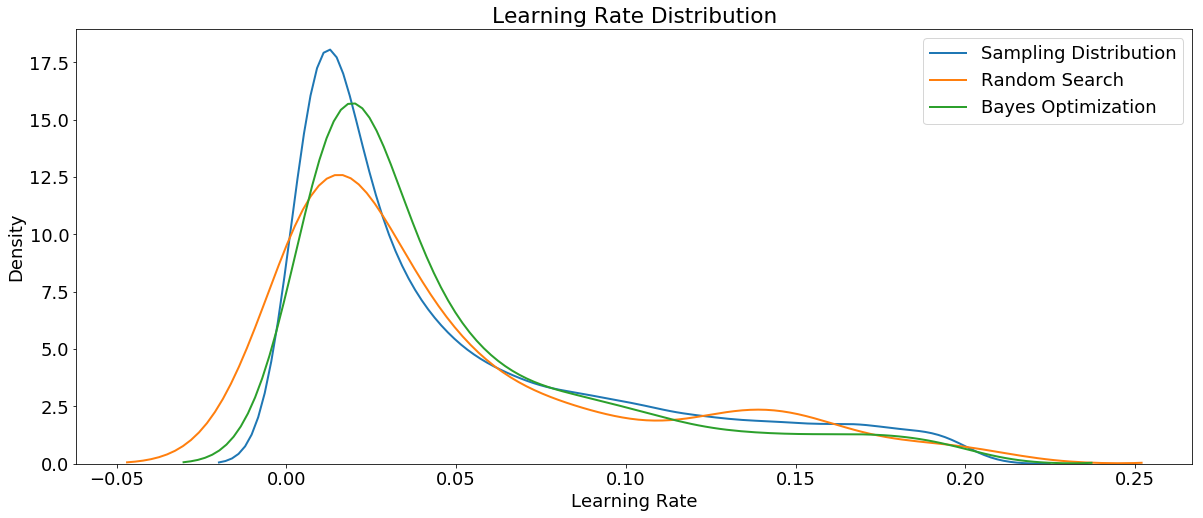

In [59]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 2)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 2)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Density')
plt.title('Learning Rate Distribution')

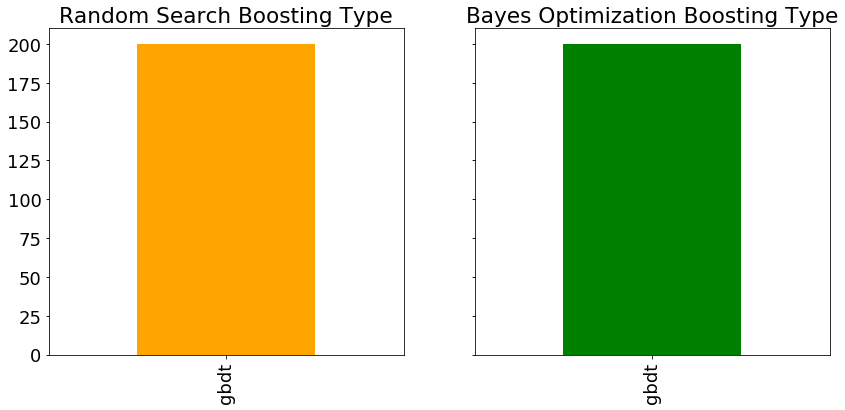

In [60]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type')

In [61]:
print('Random Search boosting type percentages')
100 * random_params['boosting_type'].value_counts() / len(random_params)

Random Search boosting type percentages


gbdt    100.0
Name: boosting_type, dtype: float64

In [62]:
print('Bayes Optimization boosting type percentages')
100 * bayes_params['boosting_type'].value_counts() / len(bayes_params)

Bayes Optimization boosting type percentages


gbdt    100.0
Name: boosting_type, dtype: float64

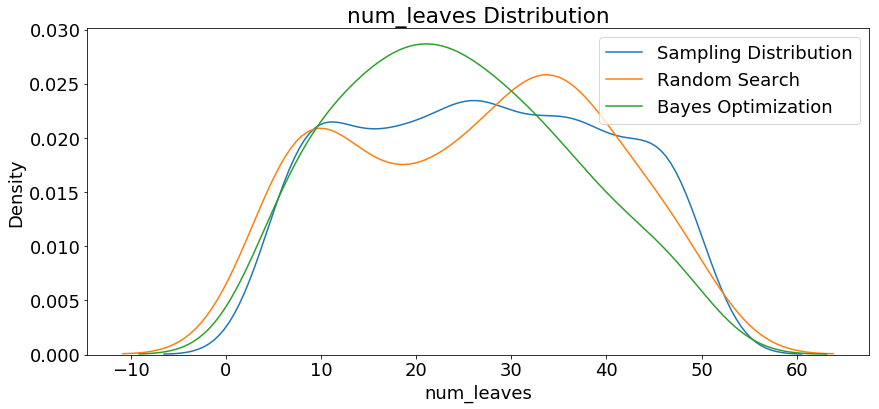

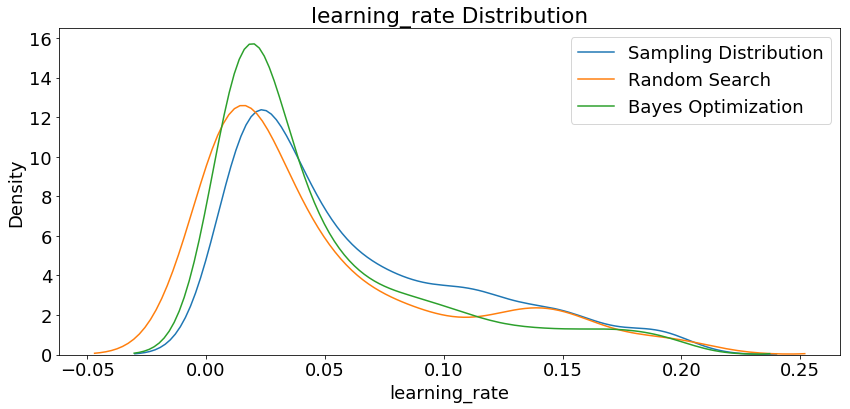

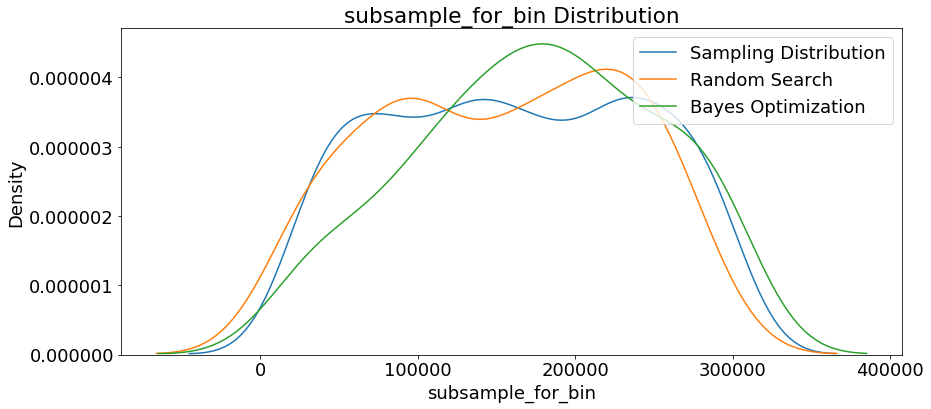

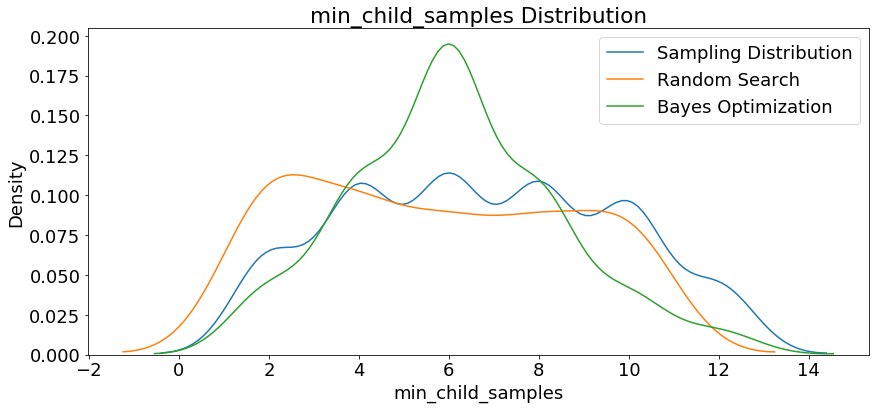

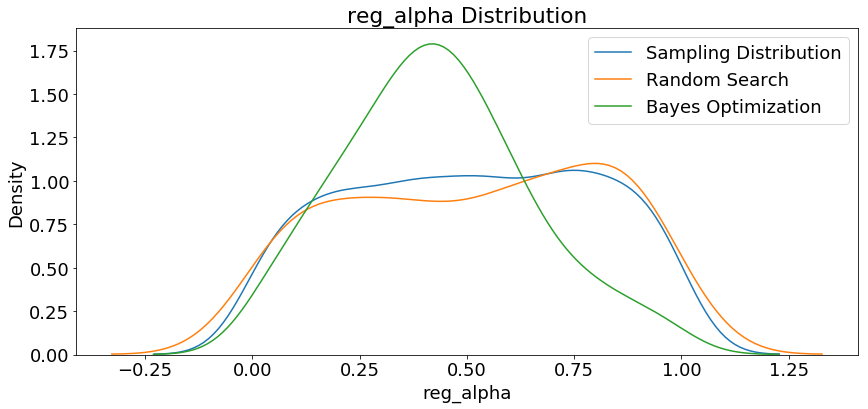

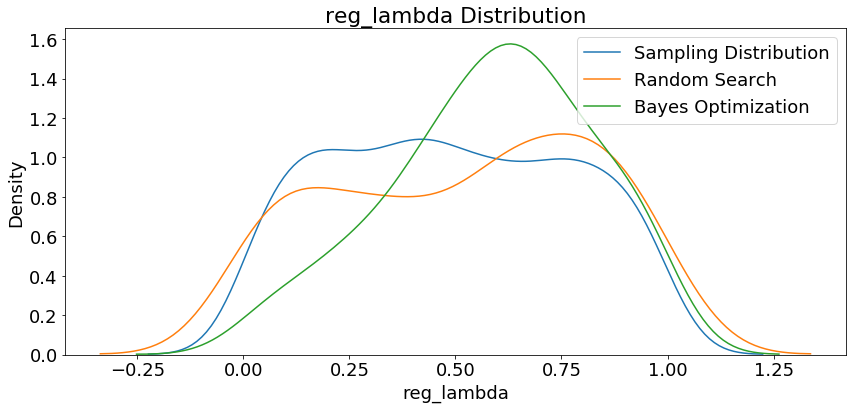

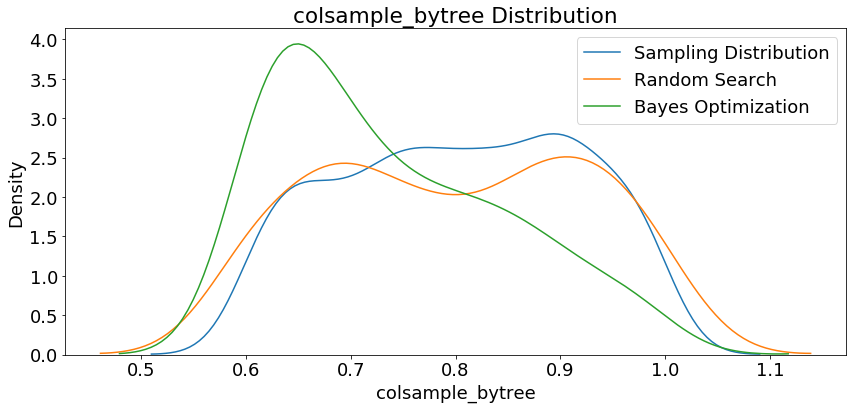

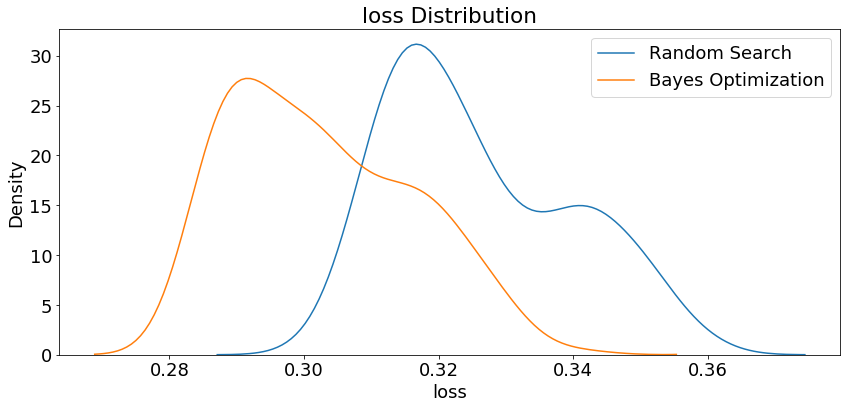

In [63]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(random_params[hyper], label = 'Random Search')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density')
        plt.show()

Text(0.5, 1.0, 'Boosting Type over Search')

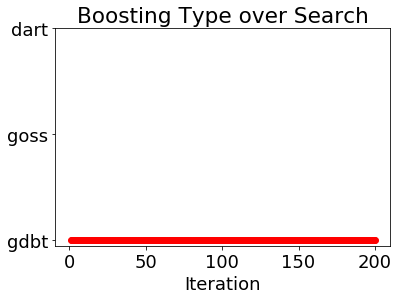

In [64]:
# Map boosting type to integer (essentially label encoding)
bayes_params['boosting_int'] = bayes_params['boosting_type'].replace({'gbdt': 1, 'goss': 2, 'dart': 3})

# Plot the boosting type over the search
plt.plot(bayes_params['iteration'], bayes_params['boosting_int'], 'ro')
plt.yticks([1, 2, 3], ['gdbt', 'goss', 'dart'])
plt.xlabel('Iteration')
plt.title('Boosting Type over Search')

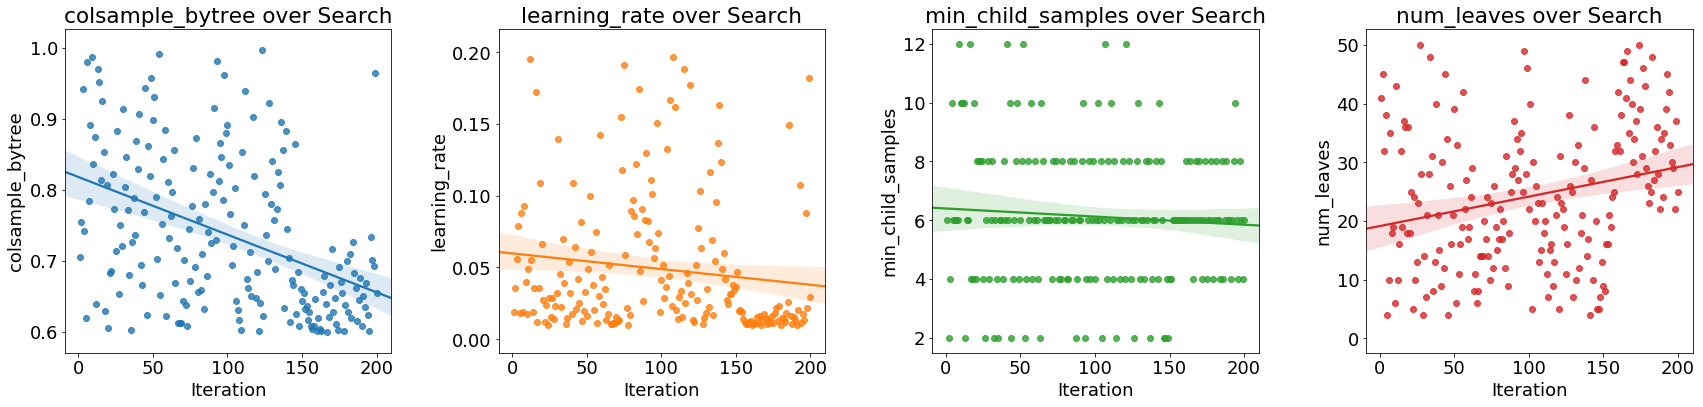

In [65]:

fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

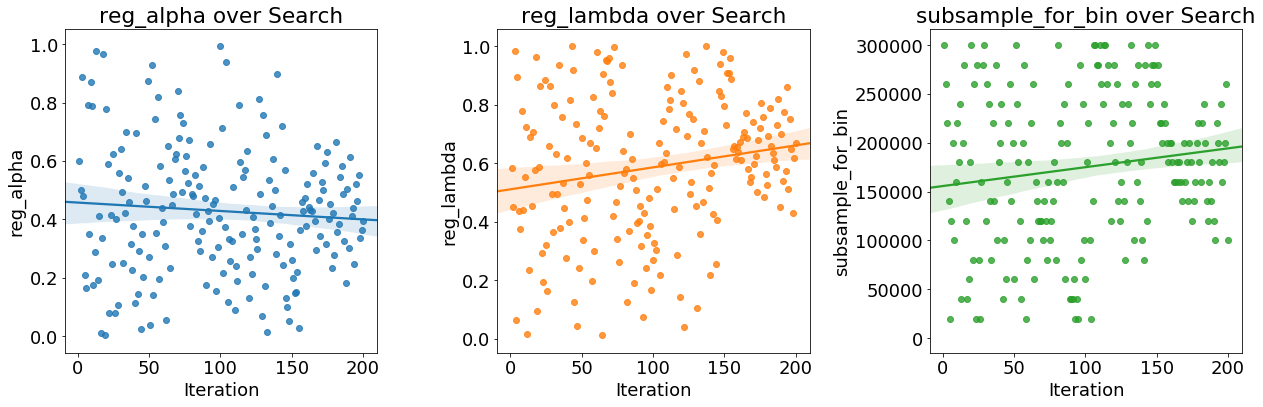

In [66]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

In [67]:
# Dataframe of just scores
scores = pd.DataFrame({'binary_logloss': random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'binary_logloss': bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'}))

scores['binary_logloss'] = scores['binary_logloss'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,binary_logloss,iteration,search
0,0.302208,18,random
1,0.304174,20,random
2,0.305384,62,random
3,0.306278,69,random
4,0.306390,113,random


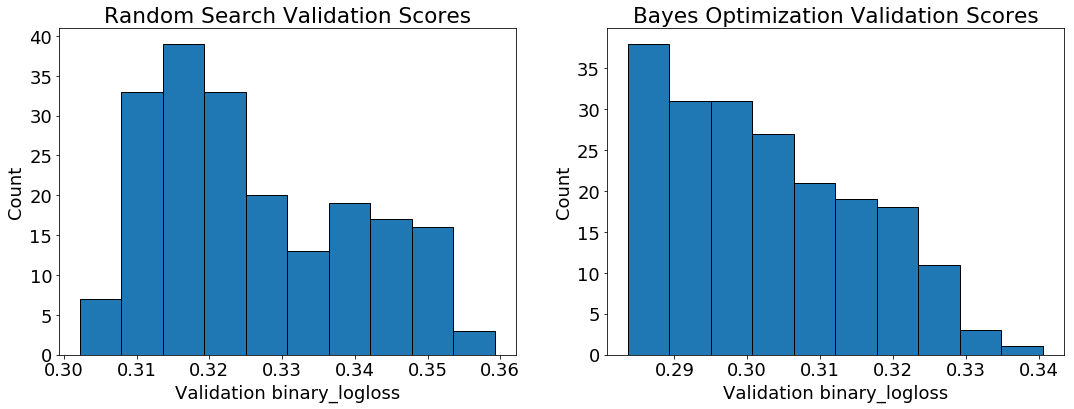

In [68]:

plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(random_results['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation binary_logloss"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
# plt.xlim(0.75, 0.78)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation binary_logloss"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
# plt.xlim(0.75, 0.78);

/home/kang/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


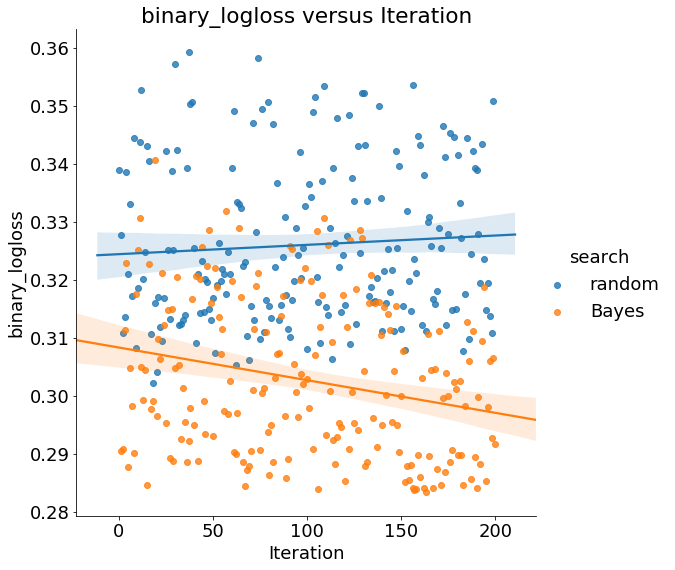

In [69]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'binary_logloss', hue = 'search', data = scores, size = 8);
plt.xlabel('Iteration'); plt.ylabel('binary_logloss'); plt.title("binary_logloss versus Iteration");

In [ ]:
import json

# Save the trial results
with open('./trials.json', 'w') as f:
    f.write(json.dumps(bayes_trials.results))

In [ ]:
# Save dataframes of parameters
bayes_params.to_csv('./bayes_params.csv', index = False)
random_params.to_csv('./random_params.csv', index = False)